In [1]:
# great ideas borrowed from 'ariel_only_correlation', https://www.kaggle.com/code/sergeifironov/ariel-only-correlation

In [1]:
import os
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import random

from ariel_calib import train_planets, test_planets, read_signal, CalibConfig 

inpdir = '../input/ariel-data-challenge-2024'
datadir = './ariel-2024-calibrated'
if not os.path.isdir(datadir):
    !unzip -q ../input/ariel-2024-calibrated/ariel-2024-calibrated.zip -d {datadir}

!ls -Llah {datadir}

time_binning = 30

ModuleNotFoundError: No module named 'ariel_calib'

In [3]:
train_labels = pd.read_csv(f'{datadir}/train_labels.csv', index_col='planet_id')

In [4]:
import itertools
from scipy.optimize import minimize
from functools import partial
import random, os

# phase_detector, try_s, calibrate_signal, calibrate_train, feature_extract
# from https://www.kaggle.com/code/sergeifironov/ariel-only-correlation
def phase_detector(signal):
    phase1, phase2 = None, None
    best_drop = 0
    for i in range(50//2,150//2):        
        t1 = signal[i:i+20//2].max() - signal[i:i+20//2].min()
        if t1 > best_drop:
            phase1 = i+(20+5)//2
            best_drop = t1
    
    best_drop = 0
    for i in range(200//2,250//2):
        t1 = signal[i:i+20//2].max() - signal[i:i+20//2].min()
        if t1 > best_drop:
            phase2 = i-5//2
            best_drop = t1
    
    return phase1, phase2

def try_s(signal, p1, p2, deg, s):
    out = list(range(p1-30)) + list(range(p2+30,signal.shape[0]))
    x, y = out, signal[out].tolist()
    x = x + list(range(p1,p2))

    y = y + (signal[p1:p2] * (1 + s[0])).tolist()
    z = np.polyfit(x, y, deg)
    p = np.poly1d(z)
    q = np.abs(p(x) - y).mean()

    if s < 1e-4:
        return q + 1e3

    return q
    
def calibrate_signal(signal):
    p1,p2 = phase_detector(signal)

    best_deg, best_score = 1, 1e12
    for deg in range(1, 4):
        f = partial(try_s, signal, p1, p2, deg)
        r = minimize(f, [0.001], method = 'Nelder-Mead')
        s = r.x[0]

        out = list(range(p1-30)) + list(range(p2+30,signal.shape[0]))
        x, y = out, signal[out].tolist()
        x = x + list(range(p1,p2))
        y = y + (signal[p1:p2] * (1 + s)).tolist()
    
        z = np.polyfit(x, y, deg)
        p = np.poly1d(z)
        q = np.abs(p(x) - y).mean()
        
        if q < best_score:
            best_score = q
            best_deg = deg
        
        print(deg, q)
            
    z = np.polyfit(x, y, best_deg)
    p = np.poly1d(z)

    return s, x, y, p(x)

def calibrate_train(signal):
    p1,p2 = phase_detector(signal)

    best_deg, best_score = 1, 1e12
    for deg in range(1, 4):
        f = partial(try_s, signal, p1, p2, deg)
        r = minimize(f, [0.0001], method = 'Nelder-Mead')
        s = r.x[0]

        out = list(range(p1-30)) + list(range(p2+30,signal.shape[0]))
        x, y = out, signal[out].tolist()
        x = x + list(range(p1,p2))
        y = y + (signal[p1:p2] * (1 + s)).tolist()
    
        z = np.polyfit(x, y, deg)
        p = np.poly1d(z)
        q = np.abs(p(x) - y).mean()
        
        if q < best_score:
            best_score = q
            best_deg = deg
            
    z = np.polyfit(x, y, best_deg)
    p = np.poly1d(z)
    
    return s, p(np.arange(signal.shape[0])), p1, p2

def feature_extract(airs_signal):
    signal = airs_signal.mean(1)
    p1, p2 = phase_detector(signal)

    # get best_deg
    best_deg, best_score, best_s = 1, 1e12, None
    for deg in range(1, 4):
        f = partial(try_s, signal, p1, p2, deg)
        r = minimize(f, [0.0001], method = 'Nelder-Mead')
        s = r.x[0]
    
        out = list(range(p1-30)) + list(range(p2+30,signal.shape[0]))
        x, y = out, signal[out].tolist()
        x = x + list(range(p1,p2))
        y = y + (signal[p1:p2] * (1 + s)).tolist()
    
        z = np.polyfit(x, y, deg)
        p = np.poly1d(z)
        q = np.abs(p(x) - y).mean()
        
        if q < best_score:
            best_score = q
            best_deg = deg
            best_s = s

    best_s = np.clip(best_s, 1e-4, 0.1)   
    return np.array([best_s])

In [5]:
from sklearn.linear_model import QuantileRegressor, Ridge
from copy import deepcopy

fit_cloned = []

class SigmaRegressor:
    def __init__(self, alpha=0):
        self.alpha = alpha
        self.l_regrs = None

    def get_params(self, deep=True):
        return {'alpha': self.alpha}

    def fit(self, X, Y, verbose=True):
        self.l_regrs = []
        for k in tqdm.tqdm(range(Y.shape[1]), disable=not verbose):
            y = Y[:, k]
            regr0 = QuantileRegressor(quantile=1-0.953, alpha=self.alpha, solver='highs').fit(X, y) # -2 * sigma
            regr1 = QuantileRegressor(quantile=0.5, alpha=self.alpha, solver='highs').fit(X, y)
            regr2 = QuantileRegressor(quantile=0.953, alpha=self.alpha, solver='highs').fit(X, y) # +2 * sigma
            self.l_regrs.append((regr0, regr1, regr2))  

        fit_cloned.append( deepcopy(self) )
        
        return self

    def predict(self, X):
        yp0, yp1, yp2 = [], [], []
        for k, (regr0, regr1, regr2) in enumerate(self.l_regrs):
            yp0.append( regr0.predict(X) )
            yp1.append( regr1.predict(X) )        
            yp2.append( regr2.predict(X) )        
        
        yp0 = np.stack(yp0, 1)
        yp1 = np.stack(yp1, 1)
        yp2 = np.stack(yp2, 1)

        return np.concatenate([yp1, (yp2 - yp0)/4], 1)  # mean, sigma

In [6]:
import tqdm

X = []
for planet_id in tqdm.tqdm(train_labels.index.values):
    airs_signal = np.load(f'{datadir}/train_{time_binning}/{planet_id}.npz')['airs']
    X.append( feature_extract(airs_signal) )

X = np.stack(X, 0)
Y = train_labels.values

100%|██████████| 673/673 [00:18<00:00, 36.13it/s]


In [7]:
from sklearn.model_selection import KFold, cross_val_predict

fit_cloned = []  # fit_cloned after cross_val_predict will contain fitted estimators for evaluating test dataset.

ntrial = 5
YP, YVar = None, None
for k in range(ntrial):
    print(f"k={k}")
    cv_split = KFold(n_splits=5, random_state=k+1234, shuffle=True).split(X,Y)
    YP1 = cross_val_predict(SigmaRegressor(), X, Y, cv=cv_split)
    YSigma1 = YP1[:, 283:]
    YP1 = YP1[:, :283]
    if YP is None:
        YP = YP1.copy()
        YVar = YSigma1**2
    else:
        YP += YP1
        YVar += YSigma1**2
        
YP /= ntrial
YSigma = np.sqrt( YVar / ntrial )

k=0


100%|██████████| 283/283 [00:18<00:00, 15.44it/s]


k=1


100%|██████████| 283/283 [00:19<00:00, 14.72it/s]


k=2


100%|██████████| 283/283 [00:19<00:00, 14.19it/s]


k=3


100%|██████████| 283/283 [00:19<00:00, 14.69it/s]


k=4


100%|██████████| 283/283 [00:19<00:00, 14.74it/s]


In [8]:
len(fit_cloned)

25

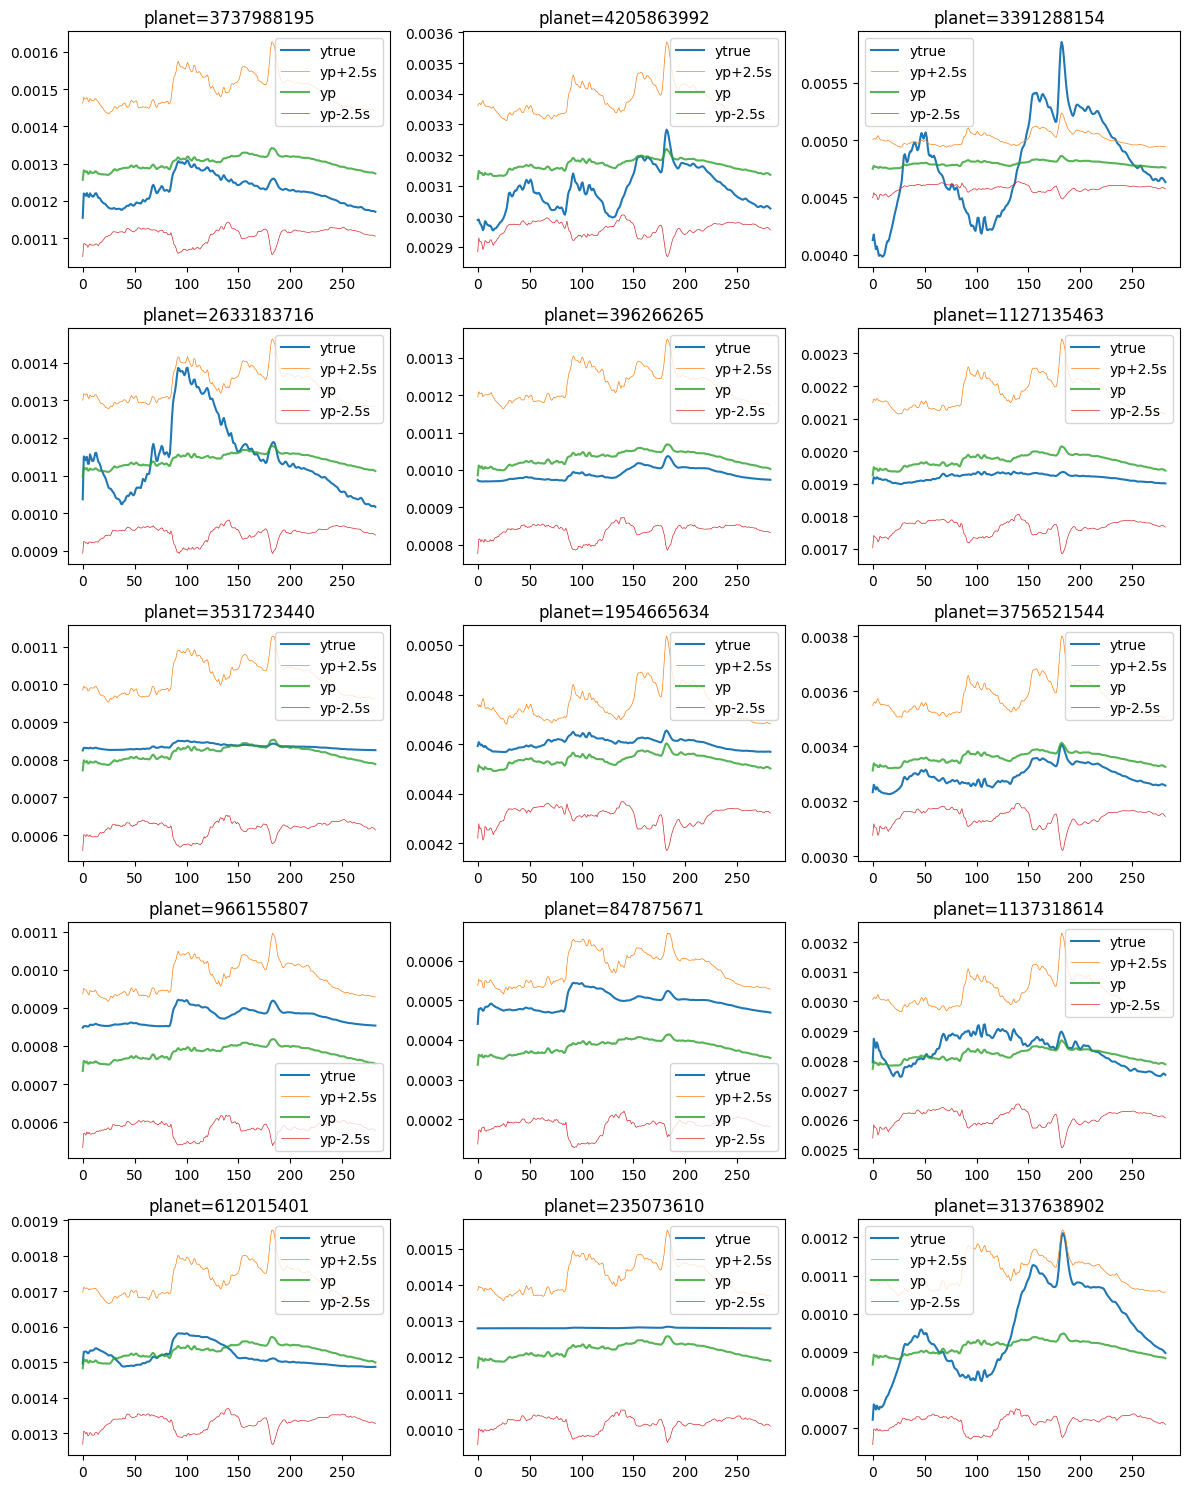

In [9]:
# sample plots
random.seed(23871)
_, axs = plt.subplots(5, 3, figsize=(3*4, 5*3))
for ax in axs.flatten():
    k = random.randint(0, len(Y)-1)
    planet_id = train_labels.index[k]
    ax.plot(Y[k], label='ytrue')
    ax.plot(YP[k] + 2.5*YSigma[k], linewidth=0.5, label='yp+2.5s')
    ax.plot(YP[k], label='yp', alpha=0.8)
    ax.plot(YP[k] - 2.5*YSigma[k], linewidth=0.5, label='yp-2.5s')
    ax.legend()
    ax.set_title(f'planet={planet_id}')
plt.tight_layout()

In [10]:
# find sigma multiplier
import scipy 

def gll(yp, ysigma, yt):
    return scipy.stats.norm.logpdf(yt, loc=yp, scale=ysigma).sum(1)

min_sigma = 1e-5
L_ideal = gll(Y, min_sigma, Y).mean()  # 2998.0983016896525
L_ref = gll(Y.flatten().mean(), Y.flatten().std(), Y).mean() # 1398.8395122870256

# find sigma multiplier
scores = []
multipliers = np.linspace(0.5, 2.0, 100)
for m in multipliers:
    score = (gll(YP, np.clip(YSigma * m, min_sigma * 5, None), Y) - L_ref) / (L_ideal - L_ref)
    score = np.clip(score, 0, None).mean()
    scores.append(score)

best_score, multiplier = np.max(scores), multipliers[np.argmax(scores)]
print(f'best_score={best_score:.4f}, sigma multiplier={multiplier:.4f}')

best_score=0.5150, sigma multiplier=0.9848


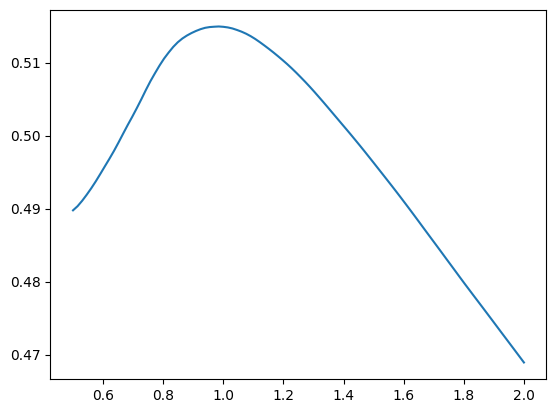

In [11]:
plt.plot(multipliers, scores)

In [12]:
import json
with open(f'{datadir}/train_{time_binning}/calib-config.json', 'rt') as f:
    conf = CalibConfig(**json.load(f))

Xtest = []
for planet_id in test_planets:
    airs_signal = read_signal(planet_id, 'airs', conf)
    Xtest.append( feature_extract(airs_signal) )
    
Xtest = np.stack(Xtest, 0)

In [13]:
YPtest, YVtest = None, None
for regr in fit_cloned:
    YP1 = regr.predict(Xtest)
    YS1 = YP1[:, 283:]
    YP1 = YP1[:, :283]
    if YPtest is None:
        YPtest = YP1.copy()
        YVtest = YS1**2
    else:
        YPtest += YP1
        YVtest += YS1**2

YPtest /= len(fit_cloned)
YPtest = np.clip(YPtest, 0, None)
YStest = np.sqrt( YVtest / len(fit_cloned) )
YStest = np.clip(YStest * multiplier, min_sigma * 5, None) 

In [14]:
submit = pd.read_csv(f'{inpdir}/sample_submission.csv')
df = pd.concat([
    pd.DataFrame({'planet_id':list(test_planets)}), 
    pd.DataFrame(np.concatenate([YPtest, YStest], 1), columns=submit.columns[1:])], axis=1)
df.to_csv('submission.csv', index=None)

In [15]:
# remove training data cache
!rm -rf {datadir}